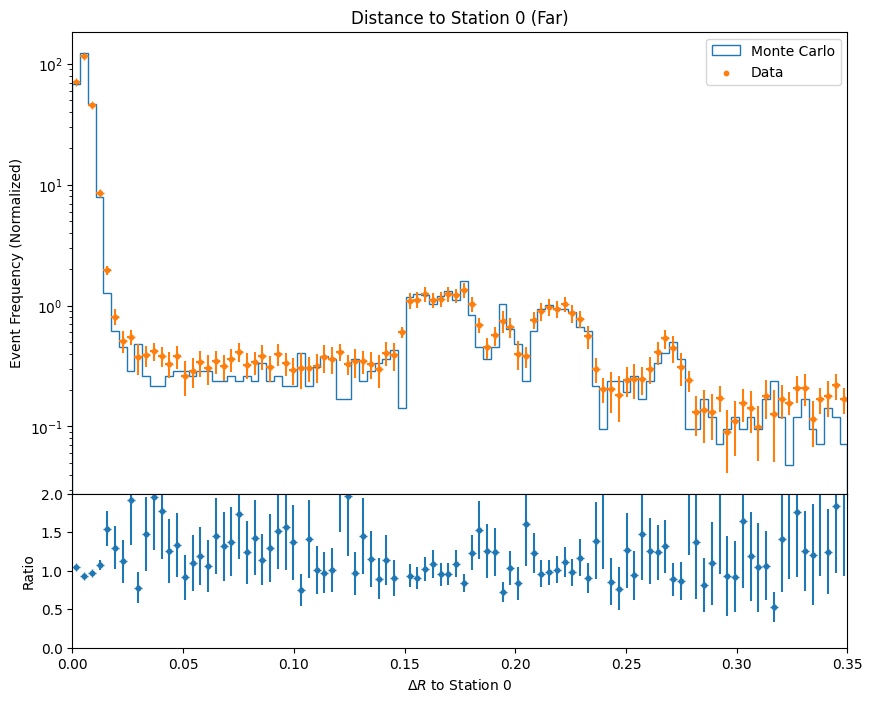

C:\Users\scien\AppData\Local\Programs\Python\Python311\Lib\site-packages\awkward\_backends\backend.py:47: RuntimeWarning: divide by zero encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)
C:\Users\scien\AppData\Local\Programs\Python\Python311\Lib\site-packages\awkward\_backends\backend.py:47: RuntimeWarning: invalid value encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)


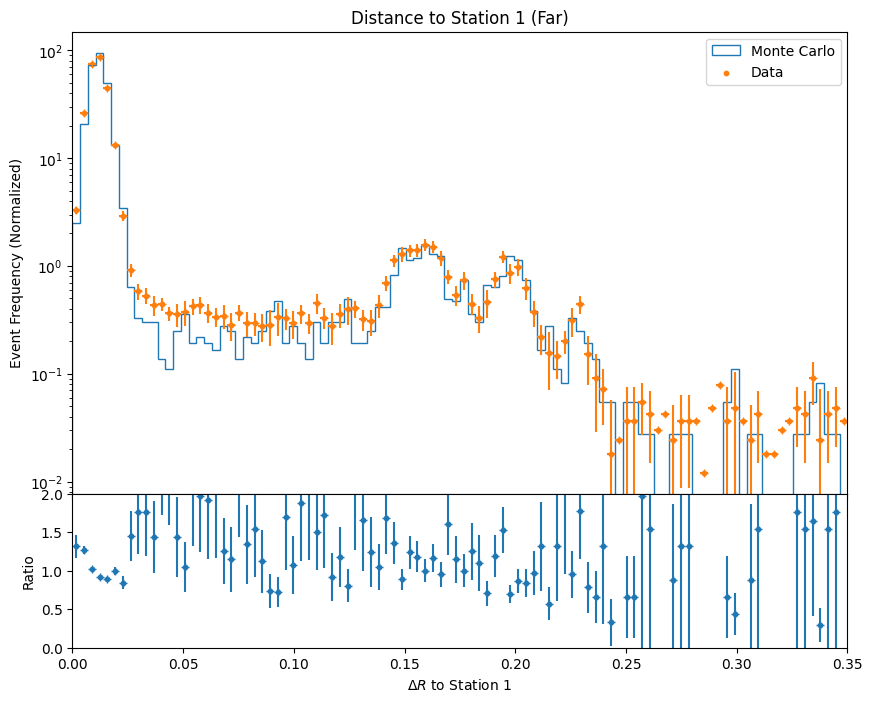

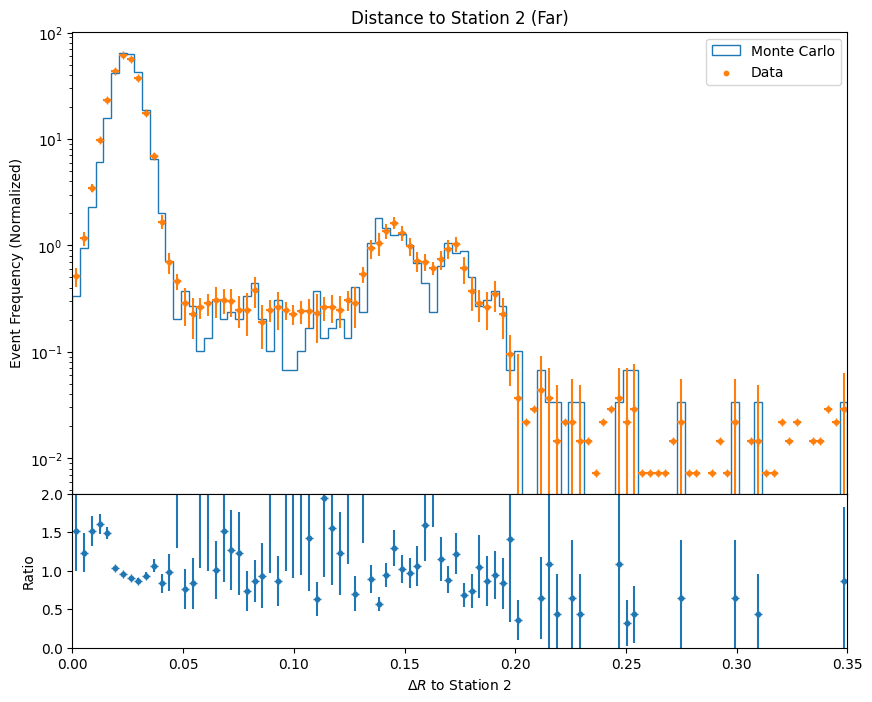

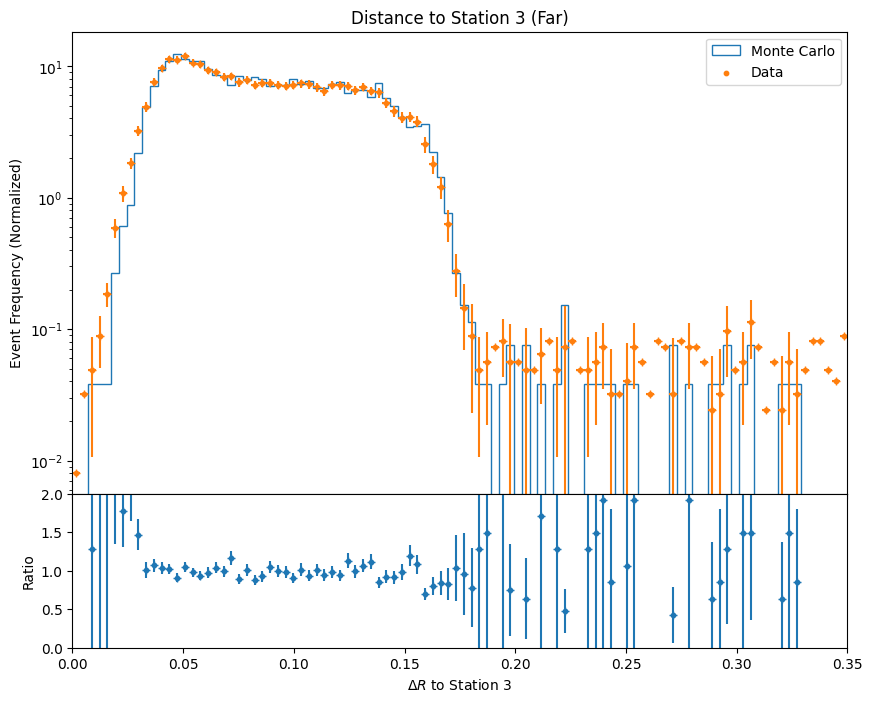

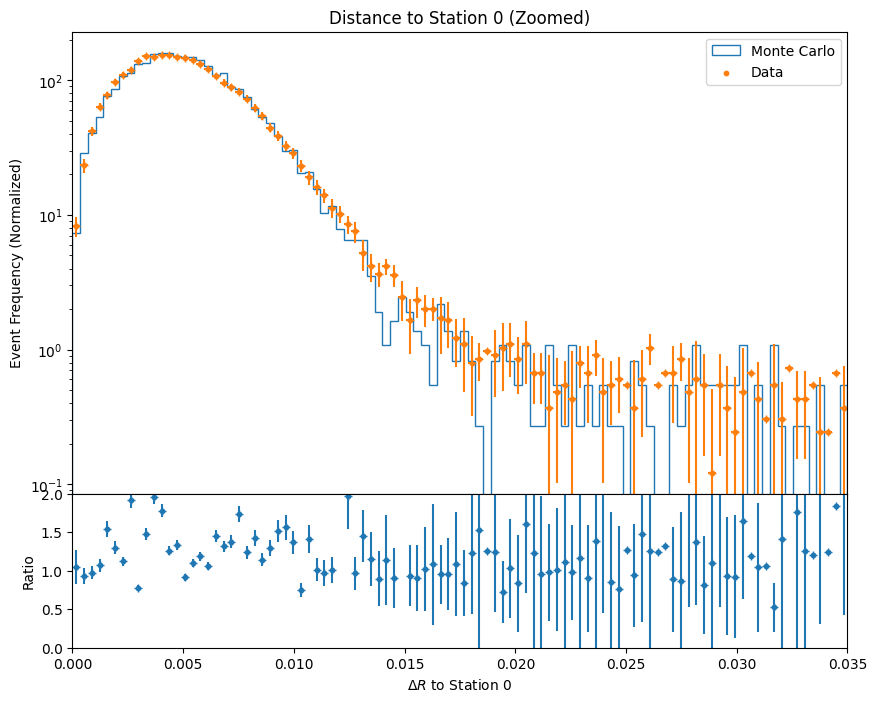

C:\Users\scien\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:3648: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


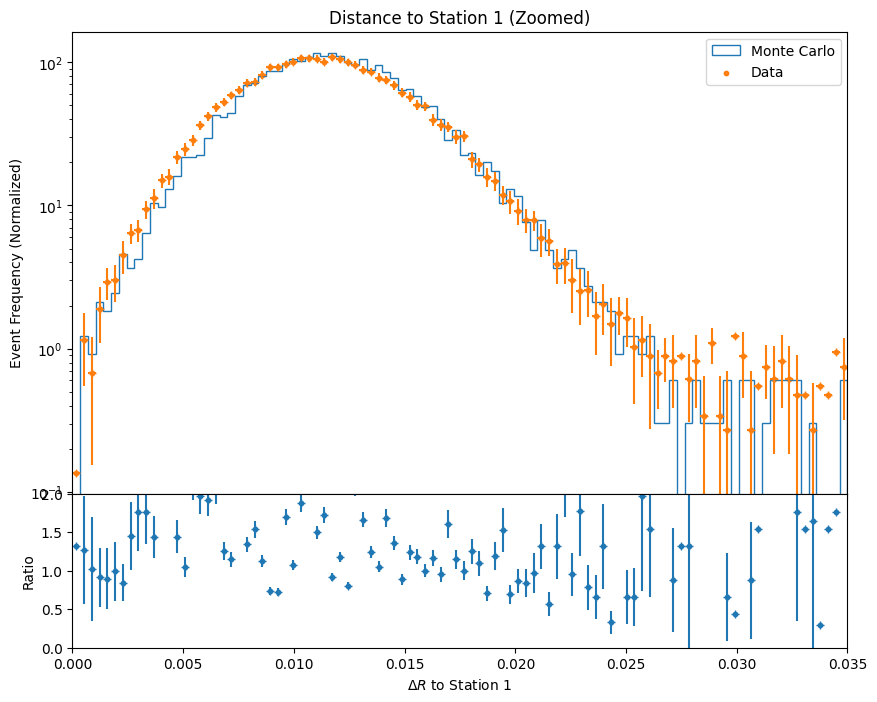

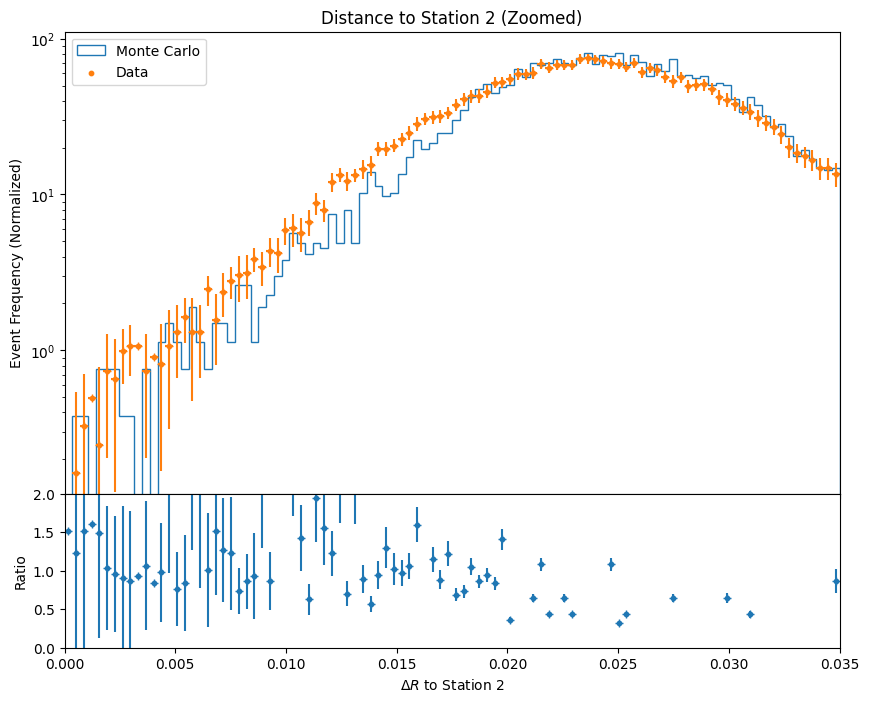

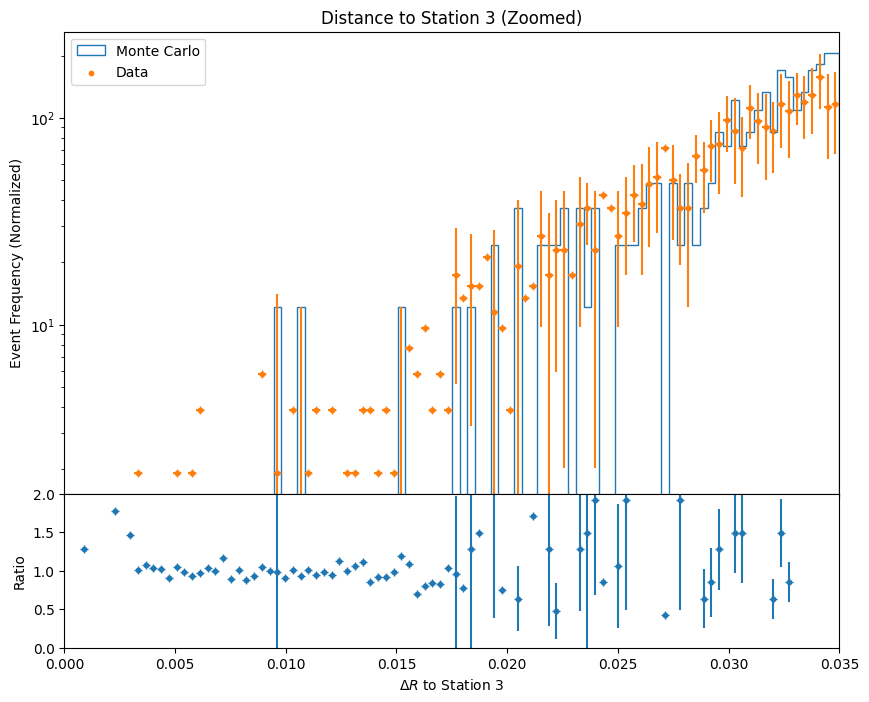

In [1]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np


class Type:
    def __init__(self, name):
        self.name = name
        self.sameSignFile = uproot.open('highHcal_'+str(self.name)+'_tagAligned (1).root')
        self.sameSignEvents = self.sameSignFile['demo']['allEvents']['sigVariables']
        self.branches = self.sameSignEvents.arrays()
        self.eta = self.branches['eta']
        self.phi = self.branches['phi']
        

Data = Type('data')
MC = Type('mc')
ratio_freq = [] # this will make sense later, keep scrolling

#Data.sameSignFile.keys()
#Data.sameSignEvents
#Data.sameSignEvents.keys()
#Data.branches['pt']

#Coord refers to eta, phi, or Delta R (DR)
class Coord:
    def __init__(self,name,x1,x2,bins):
        self.name = name
        self.x1 = x1
        self.x2 = x2
        self.bins = bins
        self.bin_width = (x2 - x1) / self.bins

DR = Coord('DR',0,0.35,100) #set delta R edges/bin


# Initialize class to help calculate normalized histograms for any data set
class NormalizedHist:
    def __init__(self, data, bins, bin_width):
        self.data = data
        self.bins = bins
        self.bin_width = bin_width
        self.norm_factor = 1 / (np.sum(self.data[0]) * self.bin_width)  # normalization factor
        self.temp = (self.data[1] + self.bin_width / 2)  # offset values by + 1/2 bin
        self.bin_centers = self.temp[:-1]  # cut last value to give bin center
        self.freq = self.data[0] * self.norm_factor  # normalized frequency
        self.err = (self.data[0] ** 0.5) * self.norm_factor  # normalized vertical error bar

# Method for plotting histograms
def plot_hist(Data_min_DT_R, MC_min_DT_R, DR, i, x2, zoom_lvl=''):
    new_bin_width = (x2 - DR.x1) / DR.bins

    # Set up histogram, use bars for Data
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [3, 1]}, figsize=(10, 8))
    axs[0].hist(MC_min_DT_R, bins=DR.bins, range=(DR.x1, x2), density=True, histtype='step', label='Monte Carlo') 
    axs[0].set_title('Distance to Station '+str(i)+ zoom_lvl)
    axs[0].set_ylabel('Event Frequency (Normalized)')
    axs[0].set_yscale('log')
    # NOTE: new_bin_width = DR.bin_width when x2=0.35; I use this new variable to define visual data resolution, 
    #       maintaining 100 bins across a smaller field of view when zoomed in - while preserving the original bin 
    #       width information to accurately calculate normalization without skew from inconsistent binning.
    

    # Create numpy histogram data for Data & MC so ratio can be calculated by initializing each as NormalizedHist Class
    # This allows calculations to be performed with attributes without using excess variables
    data_hist = NormalizedHist(np.histogram(Data_min_DT_R, bins=DR.bins, range=(DR.x1, x2), density=None), DR.bins, new_bin_width)
    mc_hist = NormalizedHist(np.histogram(MC_min_DT_R, bins=DR.bins, range=(DR.x1, x2), density=None), DR.bins, new_bin_width)

    # Scatter MC by attribute
    axs[0].scatter(data_hist.bin_centers, data_hist.freq, s=10, label='Data')
    axs[0].errorbar(data_hist.bin_centers, data_hist.freq, xerr=new_bin_width/2, yerr=mc_hist.err, fmt='+')
    axs[0].set_xlim(0, x2)
    axs[0].legend()

    # Find ratio between frequencies at each bin
    ratio_freq.append(np.divide(data_hist.freq, mc_hist.freq)) # almost there, go to next cell

    # Calculate ratio error using sketchy formula from google images (propagation of uncertainty?)
    ratio_err = ratio_freq[i] * np.sqrt((data_hist.err / data_hist.freq)**2 + (mc_hist.err / mc_hist.freq)**2)

    # Scatter ratio plot
    axs[1].scatter(data_hist.bin_centers, ratio_freq[i], s=10)
    axs[1].errorbar(data_hist.bin_centers, ratio_freq[i], yerr=ratio_err, fmt='+')
    axs[1].set_ylim(0,2)
    axs[1].set_ylabel('Ratio')
    axs[1].set_xlabel('$\Delta R$ to Station '+str(i))
    plt.show()

    
# Do the thing :D
for i in range (4):
    Data_min_DT_R = Data.branches['dtDRbyStation_'+str(i)] #min DR data
    MC_min_DT_R = MC.branches['dtDRbyStation_'+str(i)] #min DR MC
    plot_hist(Data_min_DT_R, MC_min_DT_R, DR, i, 0.35, " (Far)")

# Zoomed
for i in range (4):
    Data_min_DT_R = Data.branches['dtDRbyStation_'+str(i)] #min DR data
    MC_min_DT_R = MC.branches['dtDRbyStation_'+str(i)] #min DR MC
    plot_hist(Data_min_DT_R, MC_min_DT_R, DR, i, 0.035, " (Zoomed)")

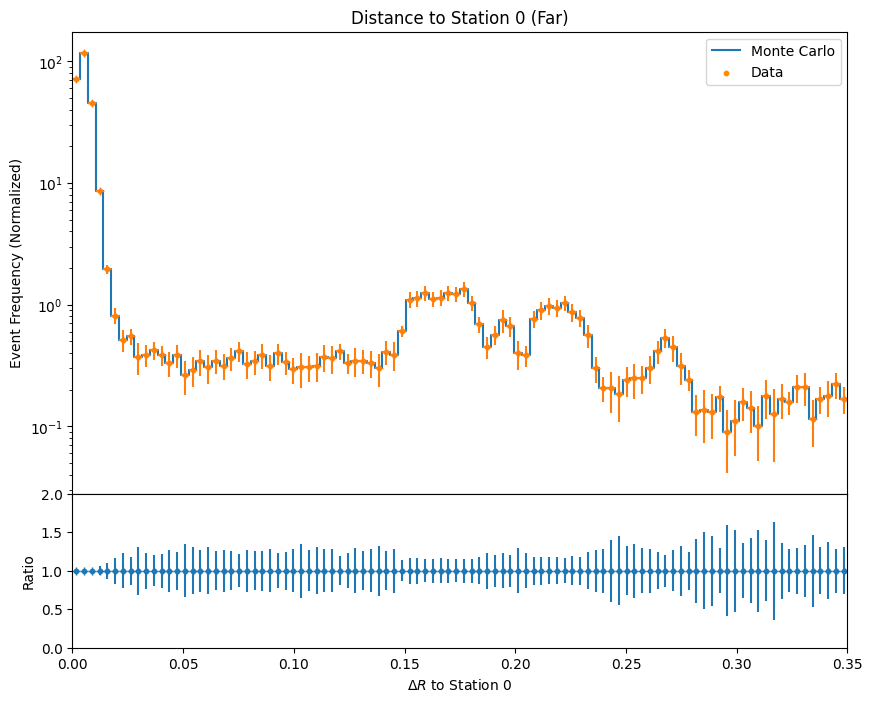

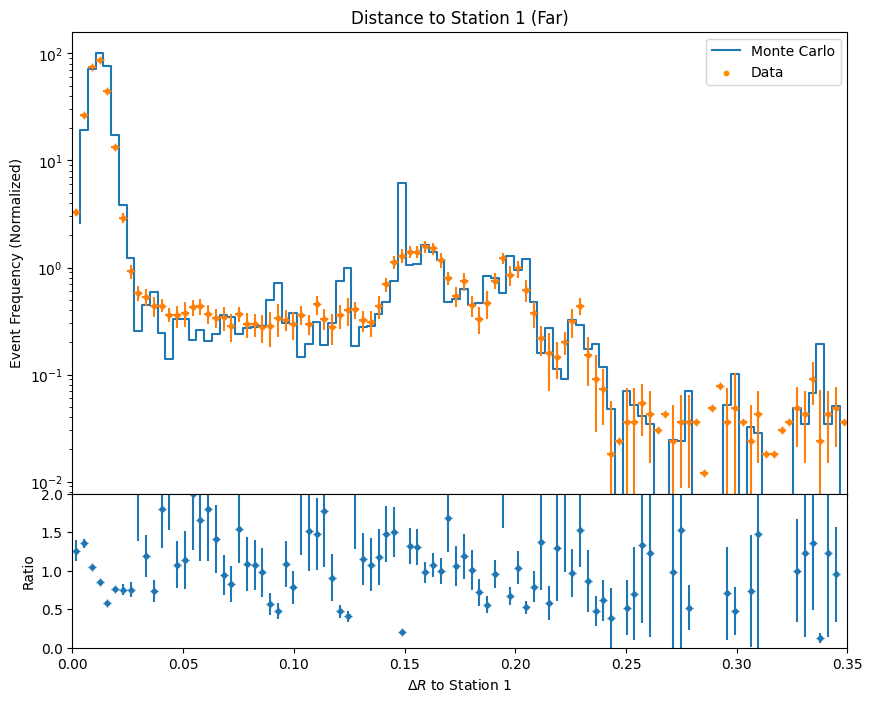

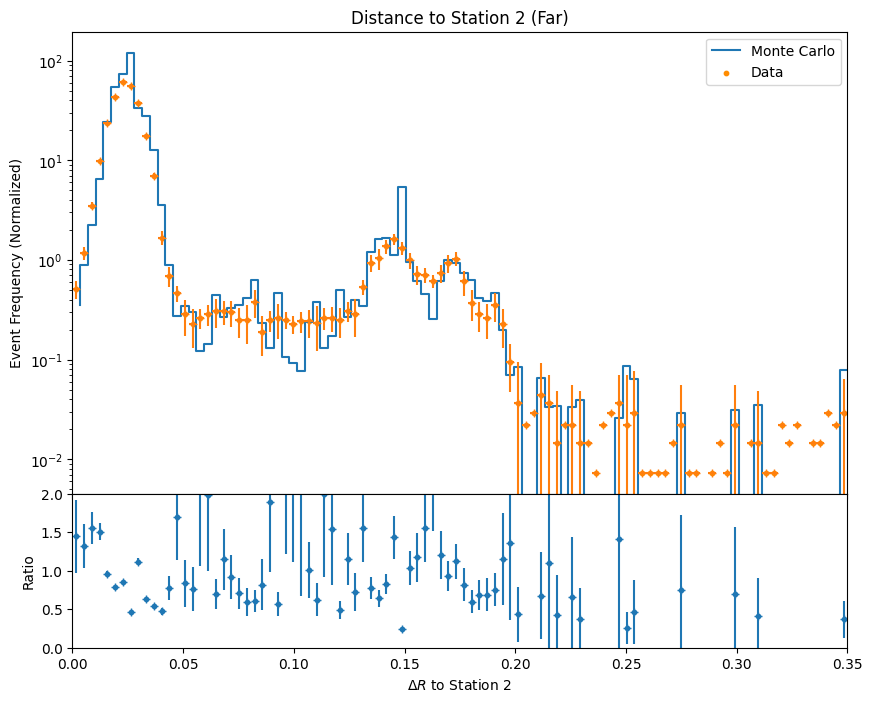

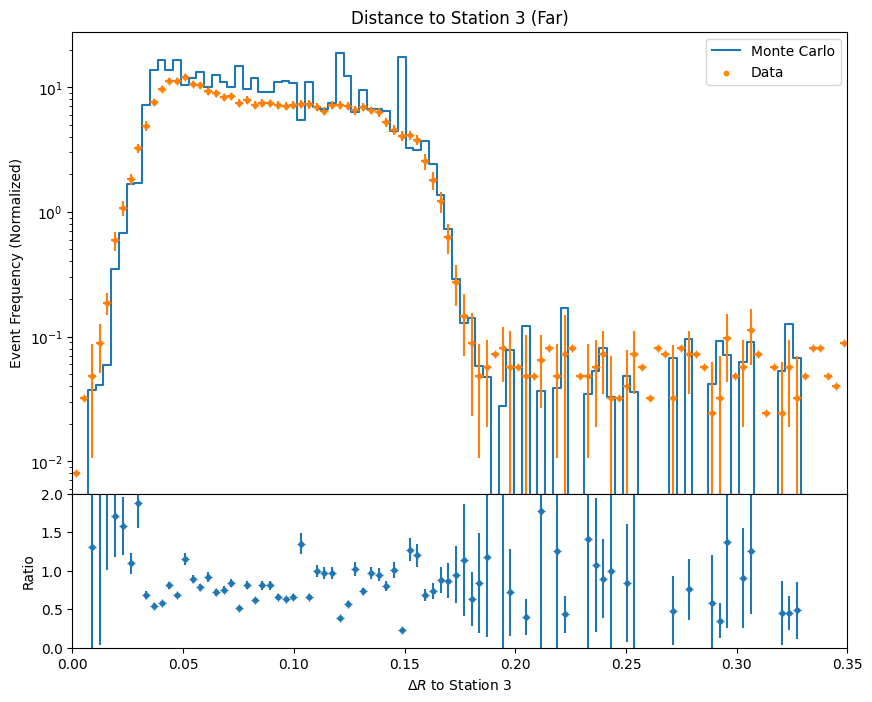

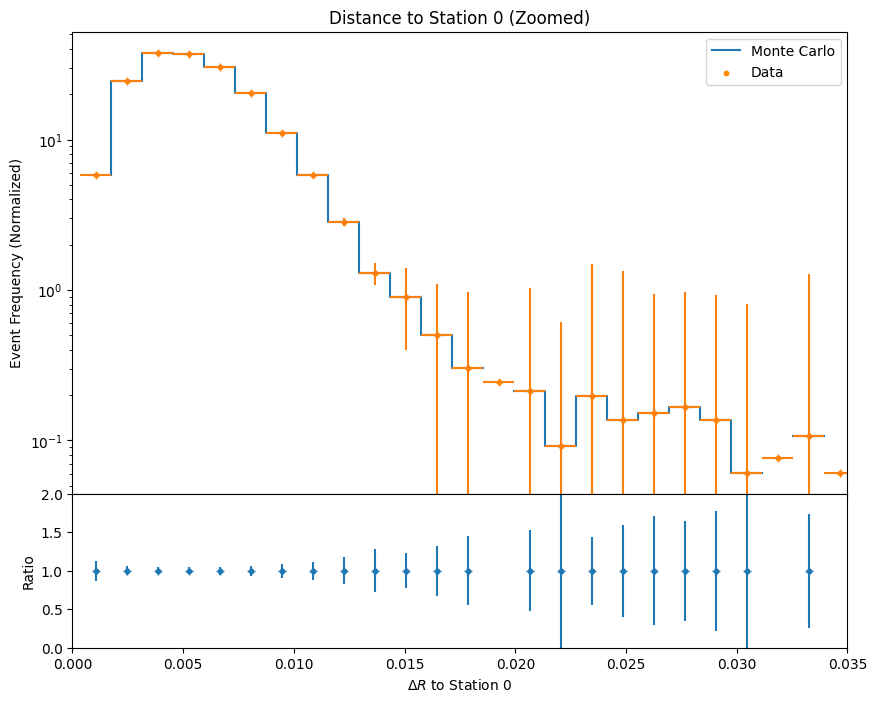

[2.07, 5.85, 10.4, 15.9, 19.4, 24.4, ..., 0.107, nan, 0.0609, nan, nan, 0.0914]


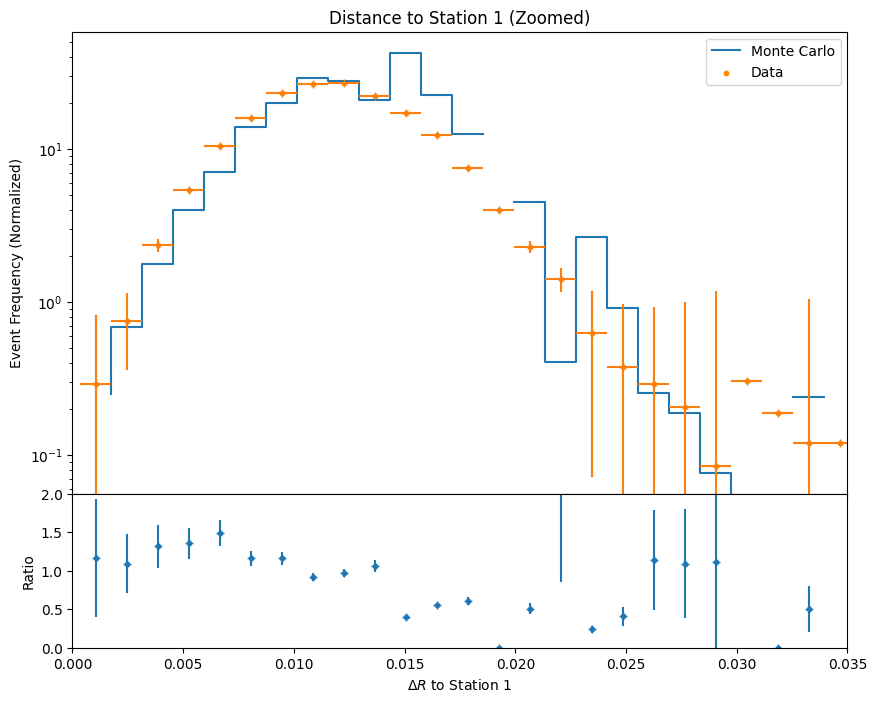

[0, 0.248, 0.235, 0.639, 0.462, 0.685, 1.15, ..., 0, inf, 0, nan, nan, 0.102]


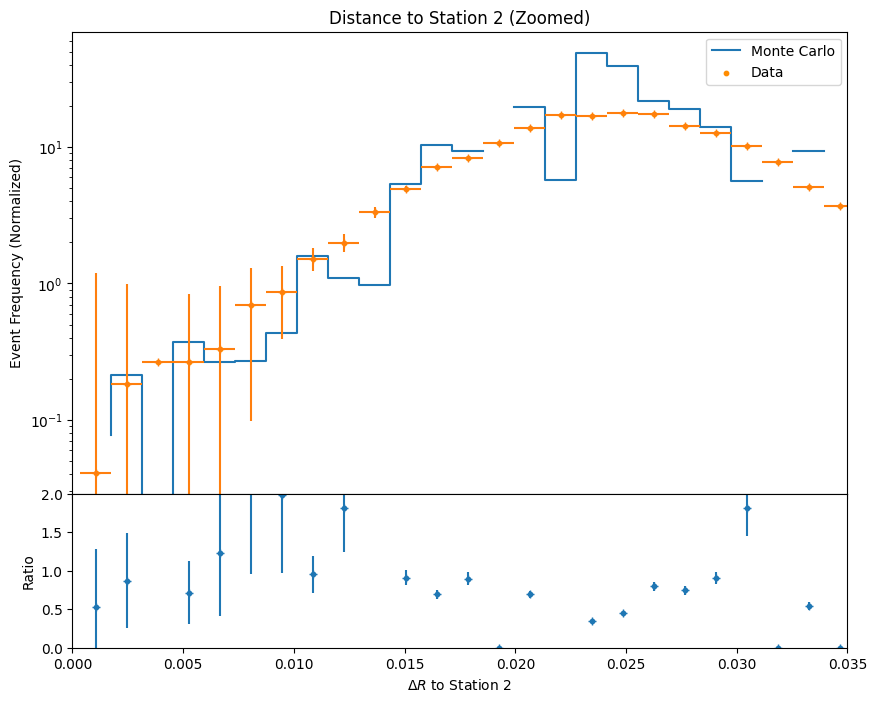

[0, 0.0771, 0.0973, 0, 0.191, 0.213, 0.191, ..., 6.94, inf, 1.9, inf, inf, 2.47]


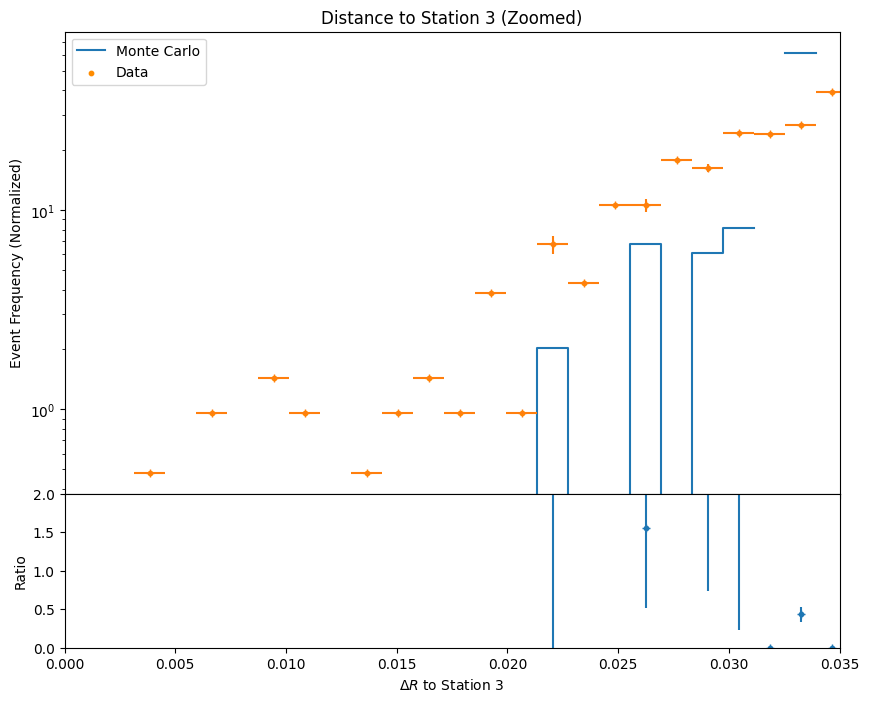

[0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 23.8, inf, 61.8, 42.8, inf, 19, inf, inf, 34.6]


In [26]:
# Method for plotting histograms
def plot_hist_adjF(Data_min_DT_R, MC_min_DT_R, DR, i, x2, zoom_lvl=''): #Far adjusted (bin size different)
    new_bin_width = (x2 - DR.x1) / DR.bins
    
    # Create numpy histogram data for Data & MC so ratio can be calculated by initializing each as NormalizedHist Class
    data_hist = NormalizedHist(np.histogram(Data_min_DT_R, bins=DR.bins, range=(DR.x1, x2), density=None), DR.bins, new_bin_width)
    mc_hist_adj = NormalizedHist(np.histogram(MC_min_DT_R, bins=DR.bins, range=(DR.x1, x2), density=None), DR.bins, new_bin_width)
    
    mc_hist_adj.freq = mc_hist_adj.freq*ratio_freq[0] # yay you found it
    mc_hist_err = ratio_freq[0] * np.sqrt((data_hist.err / data_hist.freq)**2 + (mc_hist_adj.err / mc_hist_adj.freq)**2)

    # Set up histogram, use bars for MC
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [3, 1]}, figsize=(10, 8))
    axs[0].step(mc_hist_adj.bin_centers+new_bin_width/2, mc_hist_adj.freq, label='Monte Carlo') 
    axs[0].set_title('Distance to Station '+str(i)+ zoom_lvl)
    axs[0].set_ylabel('Event Frequency (Normalized)')
    axs[0].set_yscale('log')
    
    # Scatter data by attribute
    axs[0].scatter(data_hist.bin_centers, data_hist.freq, s=10, color='darkorange', label='Data')
    axs[0].errorbar(data_hist.bin_centers, data_hist.freq, xerr=new_bin_width/2, yerr=mc_hist_adj.err, fmt='+')
    axs[0].set_xlim(0, x2)
    axs[0].legend()

    # Find ratio between frequencies at each bin
    ratio_freq_adj = np.divide(data_hist.freq, mc_hist_adj.freq) 

    # Calculate ratio error using sketchy formula from google images (propagation of uncertainty?)
    ratio_err_adj = ratio_freq_adj * np.sqrt((data_hist.err / data_hist.freq)**2 + (mc_hist_adj.err / mc_hist_adj.freq)**2)

    # Scatter ratio plot
    axs[1].scatter(data_hist.bin_centers, ratio_freq_adj, s=10)
    axs[1].errorbar(data_hist.bin_centers, ratio_freq_adj, yerr=ratio_err_adj, fmt='+')
    axs[1].set_ylim(0,2)
    axs[1].set_ylabel('Ratio')
    axs[1].set_xlabel('$\Delta R$ to Station '+str(i))
    plt.show()

    return mc_hist_adj, data_hist

# Method for plotting histograms
def plot_hist_adjZ(Data_min_DT_R, MC_min_DT_R, DR, i, x2, zoom_lvl=''): #Far adjusted (bin size different)

    new_bins = 50
    bf = DR.bins / new_bins
    new_bin_width = (x2 - DR.x1) / new_bins
    
    # Create numpy histogram data for Data & MC so ratio can be calculated by initializing each as NormalizedHist Class
    data_hist = NormalizedHist(np.histogram(Data_min_DT_R, bins=DR.bins, range=(DR.x1, x2), density=None), DR.bins, new_bin_width) #half bins
    mc_hist_adj = NormalizedHist(np.histogram(MC_min_DT_R, bins=DR.bins, range=(DR.x1, x2), density=None), DR.bins, new_bin_width) #half bins
    
    mc_hist_adj.freq = mc_hist_adj.freq*ratio_freq[4] # yay you found it
    mc_hist_err = ratio_freq[4] * np.sqrt((data_hist.err / data_hist.freq)**2 + (mc_hist_adj.err / mc_hist_adj.freq)**2)

    # Set up histogram, use bars for MC
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [3, 1]}, figsize=(10, 8))
    axs[0].step(mc_hist_adj.bin_centers[1::round(bf)]+new_bin_width/2, mc_hist_adj.freq[1::round(bf)], label='Monte Carlo') #half bins
    axs[0].set_title('Distance to Station '+str(i)+ zoom_lvl)
    axs[0].set_ylabel('Event Frequency (Normalized)')
    axs[0].set_yscale('log')
    

    # Scatter data by attribute
    axs[0].scatter(data_hist.bin_centers[1::round(bf)], data_hist.freq[1::round(bf)], s=10, color='darkorange', label='Data') #half bins
    axs[0].errorbar(data_hist.bin_centers[1::round(bf)], data_hist.freq[1::round(bf)], xerr=new_bin_width/2, yerr=mc_hist_err[1::round(bf)], fmt='+')
    axs[0].set_xlim(0, x2)
    axs[0].legend()

    # Find ratio between frequencies at each bin
    ratio_freq_adj = np.divide(data_hist.freq, mc_hist_adj.freq) 

    # Calculate ratio error using sketchy formula from google images (propagation of uncertainty?)
    ratio_err_adj = ratio_freq_adj * np.sqrt((data_hist.err / data_hist.freq)**2 + (mc_hist_adj.err / mc_hist_adj.freq)**2)

    # Scatter ratio plot
    axs[1].scatter(data_hist.bin_centers[1::round(bf)], ratio_freq_adj[1::round(bf)], s=10) #half bins
    axs[1].errorbar(data_hist.bin_centers[1::round(bf)], ratio_freq_adj[1::round(bf)], yerr=ratio_err_adj[1::round(bf)], fmt='+') #half bins
    axs[1].set_ylim(0,2)
    axs[1].set_ylabel('Ratio')
    axs[1].set_xlabel('$\Delta R$ to Station '+str(i))
    plt.show()

    print(mc_hist_adj.freq)
    

    return mc_hist_adj, data_hist


# Do the thing :D
for i in range(4):
    Data_min_DT_R = Data.branches['dtDRbyStation_' + str(i)]  # min DR data
    MC_min_DT_R = MC.branches['dtDRbyStation_' + str(i)]  # min DR MC
    plot_hist_adjF(Data_min_DT_R, MC_min_DT_R, DR, i, 0.35, " (Far)")

# Zoomed
for i in range(4):
    Data_min_DT_R = Data.branches['dtDRbyStation_' + str(i)]  # min DR data
    MC_min_DT_R = MC.branches['dtDRbyStation_' + str(i)]  # min DR MC
    plot_hist_adjZ(Data_min_DT_R, MC_min_DT_R, DR, i, 0.035, " (Zoomed)")

#############################################################################################################################repeat for each station(?)